# Activation Flip

Playing around with pytroch and trying to get an intuitive understanding of the way neurons work. In particular, what would happen if model was trainned on a negative image.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import network
import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data(flipped=True)

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


True

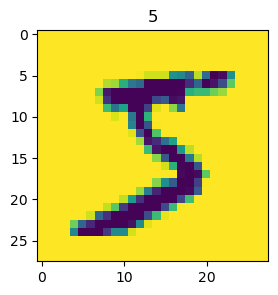

In [4]:
# negative image

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [5]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [17]:
eta = 0.3
epochs = 10

net1 = network.Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.199999809265137
 evaluation accuracy: 10.239999771118164
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 training accuracy: 11.904999732971191
epoch 1
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 15.539999961853027
 evaluation accuracy: 31.520000457763672
 evaluation accuracy: 34.47999954223633
 evaluation accuracy: 50.599998474121094
 evaluation accuracy: 48.20000076293945
 training accuracy: 39.74833297729492
epoch 2
 evaluation accuracy: 60.959999084472656
 evaluation accuracy: 57.58000183105469
 evaluation accuracy: 60.08000183105469
 evaluation accuracy: 58.099998474121094
 evaluation accuracy: 59.0
 evaluation accuracy: 59

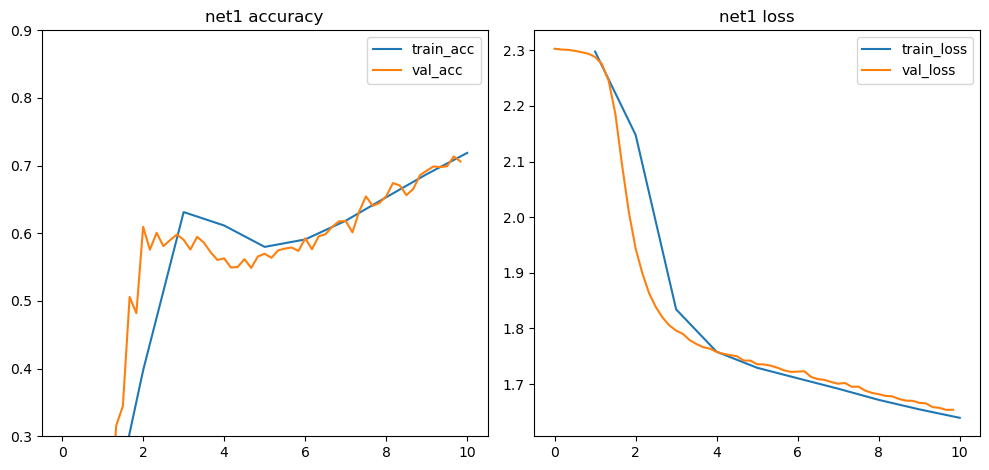

final loss: train 1.6394944399595262 v eval 1.654014978289604
final acc: train 0.7188500165939331 v eval 0.7062000036239624


In [18]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.3, .9)
ax[0].set_title('net1 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

performed slightly better than the non-negative equivalent.

In [19]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net1(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 75.18000030517578


## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [8]:
eta = 0.1
epochs = 20

# Create a SummaryWriter instance
writer = SummaryWriter()

net2 = network.Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
    
total_loss = 0.
total_acc = (0, 0)

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net2.eval() # evaluation mode
            
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
                
            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)
    

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 41.7599983215332
 training accuracy: 26.780000686645508
 evaluation accuracy: 50.220001220703125
 training accuracy: 36.880001068115234
 evaluation accuracy: 56.0
 training accuracy: 42.52000045776367
 evaluation accuracy: 9.199999809265137
 training accuracy: 22.030000686645508
 evaluation accuracy: 9.199999809265137
 training accuracy: 9.829999923706055
 evaluation accuracy: 9.199999809265137
 training accuracy: 9.949999809265137
epoch 1
 evaluation accuracy: 9.199999809265137
 training accuracy: 10.020000457763672
 evaluation accuracy: 9.199999809265137
 training accuracy: 10.600000381469727
 evaluation accuracy: 9.199999809265137
 training accuracy: 9.720000267028809
 evaluation accuracy: 9.199999809265137
 training accuracy: 9.260000228881836
 evaluation acc

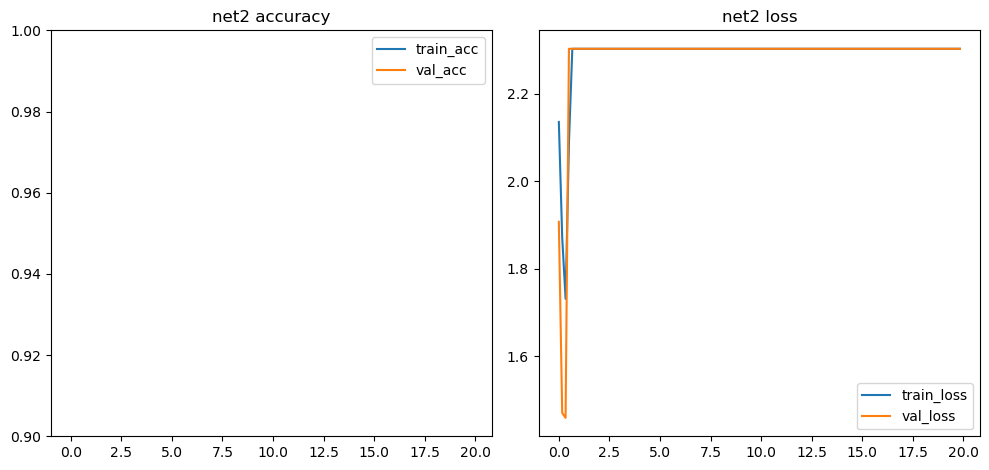

final loss: train 2.3025853633880615 v eval 2.3025851249694824
final acc: train 0.09929999709129333 v eval 0.09200000017881393


In [11]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.0)
ax[0].set_title('net2 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

In [13]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 10.399999618530273


No learning at all. Aggressively converging towards low accuracy. The difference between Network1 and Network2 is the activation function.

## Network 3
1 Convolutional layer, 2 fully connected layers.

In [14]:
eta = 0.1
epochs = 20
l2_lambda = 0.01
dropout = 0.2

# Create a SummaryWriter instance
writer = SummaryWriter()

net3 = network.Network3(dropout=dropout)
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
    
total_loss = 0.
total_acc = (0, 0)

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))

            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0


 evaluation accuracy: 82.37999725341797
 training accuracy: 57.529998779296875
 evaluation accuracy: 91.27999877929688
 training accuracy: 89.5
 evaluation accuracy: 93.08000183105469
 training accuracy: 92.16000366210938
 evaluation accuracy: 94.19999694824219
 training accuracy: 94.33999633789062
 evaluation accuracy: 95.08000183105469
 training accuracy: 95.19000244140625
 evaluation accuracy: 95.63999938964844
 training accuracy: 95.37000274658203
epoch 1
 evaluation accuracy: 95.72000122070312
 training accuracy: 96.33000183105469
 evaluation accuracy: 96.18000030517578
 training accuracy: 96.55999755859375
 evaluation accuracy: 96.45999908447266
 training accuracy: 96.54000091552734
 evaluation accuracy: 96.95999908447266
 training accuracy: 96.87999725341797
 evaluation accuracy: 96.81999969482422
 training accuracy: 97.2300033569336
 evaluation accuracy: 97.19999694824219
 training accuracy: 97.25
epoch 2
 evaluation accuracy: 97.4000015258789
 training accuracy: 97.41000366210

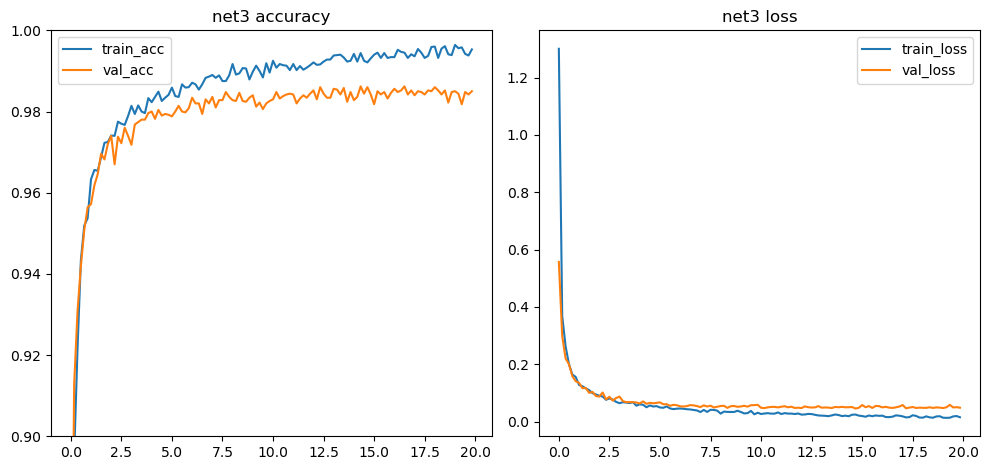

final loss: train 1.300435097515583 v eval 0.36827513843774795
final acc: train 0.9952999949455261 v eval 0.9850000143051147


In [15]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.)
ax[0].set_title('net3 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
# ax[1].set_ylim(0.0, 1.)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.legend()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {train_loss[0]} v eval {train_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Minimal overfitting.

In [16]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net3(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 99.4800033569336
